In [1]:
import re

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from ALLCools.plot import *
from matplotlib import patches
from matplotlib.cm import get_cmap
from matplotlib.colors import ListedColormap, Normalize

In [2]:
from matplotlib import rc
labelsize = 6
linewidth = 0.6
rc('lines', linewidth=linewidth)
rc('axes', labelsize=labelsize, linewidth=linewidth)
rc('xtick', labelsize=labelsize)
rc('ytick', labelsize=labelsize)
rc('xtick.major', width=linewidth)
rc('ytick.major', width=linewidth)
rc('xtick.minor', width=linewidth - 0.2)
rc('ytick.minor', width=linewidth - 0.2)

## Gene metadata

In [3]:
gene_meta = pd.read_csv(
    '/home/hanliu/ref/mouse/gencode/vm22/gencode.vM22.annotation.gene.flat.tsv.gz',
    sep='\t',
    index_col='gene_id')
gene_name_to_id = {v: k for k, v in gene_meta['gene_name'].items()}

tf_genes = pd.read_csv(
    '/home/hanliu/ref/TFGene/TFClass/TFClass.with_mouse_gene_id.csv',
    index_col=0)
tf_genes = set(','.join(tf_genes['EnsemblID'].dropna()).split(','))
gene_meta['is_tf'] = gene_meta.index.map(lambda i: i.split('.')[0] in tf_genes)

zfp_pattern = r'Zfp\d+'
p = re.compile(zfp_pattern)
gene_meta.loc[gene_meta['gene_name'].apply(lambda i: p.search(i) is not None
                                           ), 'is_tf'] = True
tf_gene_names = set(gene_meta[gene_meta['is_tf']]['gene_name'].tolist())

In [4]:
remove_gene_pattern = r'(Gm\d+)|(.+Rik)'
p = re.compile(remove_gene_pattern)

keep_gene = gene_meta[
    gene_meta['gene_name'].apply(lambda i: p.search(i) is None)].index

## Cell Tidy Data

In [5]:
cell_tidy_data = pd.read_msgpack(
    '/home/hanliu/project/mouse_rostral_brain/study/ClusteringSummary/Summary/TotalClusteringResults.msg'
)
cell_tidy_data = cell_tidy_data[cell_tidy_data['CellClass'] == 'Exc']
cell_tidy_data = cell_tidy_data[
    cell_tidy_data['SubType'].apply(lambda i: 'Outlier' not in i)].copy()

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
subtype_palette = pd.read_csv(
    '/home/hanliu/project/mouse_rostral_brain/metadata/palette/sub_type.palette.csv',
    header=None,
    index_col=0,
    squeeze=True).to_dict()

## Tree and gene assignment

In [7]:
dendro = joblib.load(
    f'/home/hanliu/project/mouse_rostral_brain/study/AssignGeneToTree/RTree/Exc.dendrogram.lib'
)
linkage = pd.read_csv(
    f'/home/hanliu/project/mouse_rostral_brain/study/AssignGeneToTree/RTree/Exc.linkage.csv',
    index_col=0)
node_dict = joblib.load(
    f'/home/hanliu/project/mouse_rostral_brain/study/AssignGeneToTree/RTree/Exc.non_singleton_node_dict.lib'
)
gene_assignment = pd.read_msgpack(
    f'/home/hanliu/project/mouse_rostral_brain/study/AssignGeneToTree/ExcGeneToTree/NodeGeneResults.msg'
)
gene_assignment = gene_assignment.loc[:,
                                      gene_assignment.columns.isin(keep_gene
                                                                   )].copy()
gene_assignment.columns = gene_assignment.columns.map(gene_meta['gene_name'])

In [8]:
tf_gene_assignment = gene_assignment.loc[:,
                                         gene_assignment.columns.
                                         isin(tf_gene_names)]
other_gene_assignment = gene_assignment.loc[:, ~gene_assignment.columns.
                                            isin(tf_gene_names)]

## Normalize linkage height to 0-1

In [9]:
linkage['2'] = linkage['2'] / linkage['2'].max()

## Plot

In [10]:
rs_abs_min = 0.3

records = tf_gene_assignment.unstack().reset_index()
records.columns = ['gene', 'node', 'relevant_score']
use_data = records[records['relevant_score'].abs() > rs_abs_min].reset_index(
    drop=True)
use_data['relevant_score_abs'] = use_data['relevant_score'].abs()

n_leaves = len(dendro['ivl'])
node_height = linkage['2'].copy()
node_height.index = node_height.index
use_data['node_height'] = use_data['node'].map(node_height).reset_index(
    drop=True)
use_data.head()
print(use_data.shape)

use_data['impact'] = use_data['relevant_score_abs'] * use_data['node_height']
total_rs_data = use_data.groupby('gene')['impact'].sum().sort_values()

tf_total_data = use_data
tf_sum_rs = total_rs_data

(2422, 5)


In [11]:
records = other_gene_assignment.unstack().reset_index()
records.columns = ['gene', 'node', 'relevant_score']
use_data = records[records['relevant_score'].abs() > rs_abs_min].reset_index(
    drop=True)
use_data['relevant_score_abs'] = use_data['relevant_score'].abs()

n_leaves = len(dendro['ivl'])
node_height = linkage['2'].copy()
node_height.index = node_height.index
use_data['node_height'] = use_data['node'].map(node_height).reset_index(
    drop=True)
use_data.head()
print(use_data.shape)

use_data['impact'] = use_data['relevant_score_abs'] * use_data['node_height']
total_rs_data = use_data.groupby('gene')['impact'].sum().sort_values()

other_total_data = use_data
other_sum_rs = total_rs_data

(31546, 5)


In [12]:
from adjustText import adjust_text

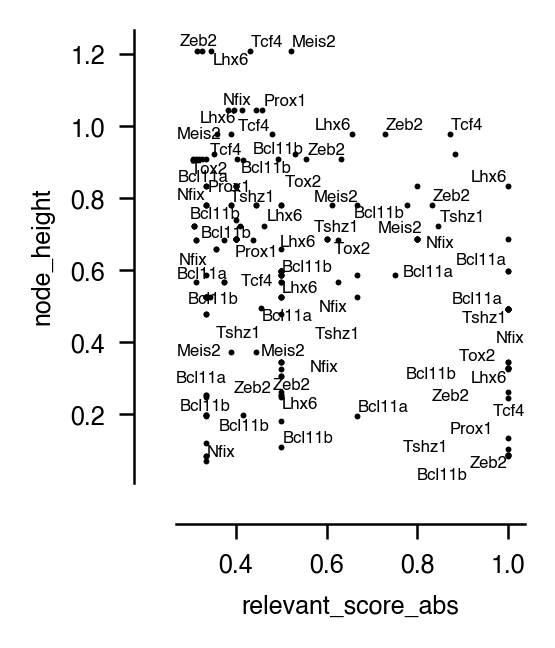

In [14]:
fig, ax = plt.subplots(figsize=(1.5, 2), dpi=300)

sns.scatterplot(data=use_data,
                ax=ax,
                s=2,
                color='k',
                linewidth=0,
                x='relevant_score_abs',
                y='node_height')

texts = []
plot_names = use_data['gene'].value_counts()[:10].index
for _, row in use_data.iterrows():
    if row['gene'] not in plot_names:
        continue
    t = ax.text(row['relevant_score_abs'],
                row['node_height'],
                row['gene'],
                ha='center',
                va='center',
                fontsize=4)
    texts.append(t)

adjust_text(texts)

sns.despine(ax=ax, offset=10)

## TF genes

In [15]:
(tf_sum_rs / len(node_dict)).sort_values(ascending=False)[:12]

gene
Zfp462    0.104729
Foxp1     0.097170
Nfia      0.095198
Satb1     0.092968
Arnt2     0.092294
Hivep1    0.091449
Zbtb16    0.091409
Meis2     0.090873
Trps1     0.089524
Klf12     0.088261
Rfx3      0.087800
Bcl11b    0.087510
Name: impact, dtype: float64

In [32]:
tf_sum_rs[tf_sum_rs > 0.5]

gene
Klf6       0.514816
Zfhx2      0.516311
Ebf4       0.516542
Zfp316     0.522443
Zfp280d    0.524584
             ...   
Arnt2      6.183668
Satb1      6.228843
Nfia       6.378253
Foxp1      6.510389
Zfp462     7.016831
Name: impact, Length: 264, dtype: float64

In [14]:
tf_sum_rs.sort_values(ascending=False)[-30:]

gene
Atoh8      0.183518
Nr4a1      0.180249
Zfp787     0.180249
Mlxip      0.180249
Zbtb38     0.180249
Zfp654     0.180249
Ehf        0.180249
Lrrfip1    0.180249
Smarce1    0.180249
Glis2      0.176727
Tfap4      0.176727
Esrrb      0.173261
Nr1h2      0.173261
Hinfp      0.173261
Tshz1      0.171975
Zfp469     0.171975
Uba2       0.162379
Mier3      0.158502
Zfp72      0.135316
Zkscan7    0.131575
Stat4      0.131575
Nr2f2      0.131575
Klf15      0.131575
Dnmt3a     0.131575
Zfp518b    0.131575
Zfp882     0.131575
Zfp715     0.131575
Zfp775     0.112643
Crem       0.104716
Zfp866     0.066487
Name: impact, dtype: float64

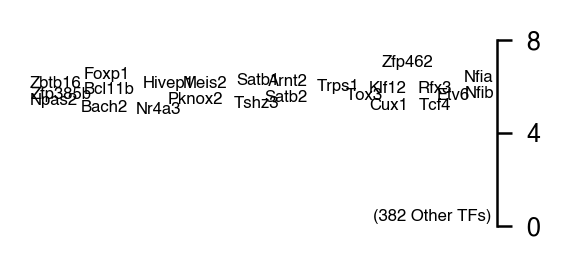

In [43]:
from matplotlib import patches
import numpy as np

label_y_cutoff = 5

df = tf_sum_rs[tf_sum_rs > label_y_cutoff]
other_count = tf_sum_rs[tf_sum_rs <= label_y_cutoff].size
df[f'({other_count} Other TFs)'] = 0.2

# c=[groupColors.get(langnameGroup[label],'k') for label in df.index]
fig = plt.figure(figsize=(2, 1), dpi=300)
gs = fig.add_gridspec(1, 10)

ax = fig.add_subplot(gs[0, :])
# ax_scatter = fig.add_subplot(gs[0, 9:])

ax.axes.get_xaxis().set_visible(False)
ax.set_xlim(-40, 0.1)
ax.set_ylim(0, 8)
ax.set_yticks([0, 4, 8])

ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.yaxis.set_label_position('right')
ax.yaxis.set_ticks_position('right')

plt.tight_layout()

patch = patches.Rectangle((-0.1, 0), 0.2, 100, fill=False, alpha=0)
# We add a rectangle to make sure the labels don't move to the right
ax.add_patch(patch)

texts = []
np.random.seed(0)
for label, y in zip(df.index, df):
    texts += [
        ax.text(
            -.1 + np.random.random() / 1000,
            y + np.random.random() / 1000,
            label,
            # A small random shift prevents labels
            # which have exactly the same coordinates from being stuck together
            # (not a problem in this example really, but wanted to mention this possibility)
            color='k',
            fontsize=4)
    ]
adjust_text(
    texts,
    [0 for _ in df],
    df,
    ha='left',
    va='center',
    add_objects=[patch],
    expand_text=(1.05, 1),
    # We want them to be quite compact, so reducing expansion makes sense
    force_text=(0.75, 0),
    force_objects=(1, 0),
    #With default forces it takes a very long time to converge,
    # but higher values still produce very nice output
    autoalign=False,
    only_move={
        'points': 'x',
        'text': 'x',
        'objects': 'x'
    })

fig.savefig('Exc.TF.total_rs.strip_plot.text_part.pdf', bbox_inches='tight')

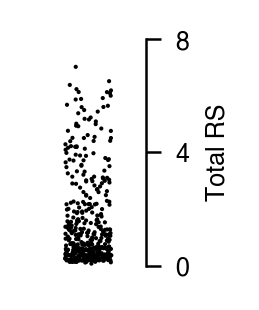

In [42]:
fig, ax = plt.subplots(figsize=(0.5, 1), dpi=300)
sns.stripplot(y=tf_sum_rs, jitter=0.2, s=1, color='k')
sns.despine(ax=ax, bottom=True, left=True, right=False)
ax.set_ylabel('Total RS')
ax.yaxis.set_label_position('right')
ax.yaxis.set_ticks_position('right')
ax.set_ylim(0, 8)
ax.set_yticks([0, 4, 8])

ax.set_xticks([])

fig.savefig('Exc.TF.total_rs.strip_plot.scatter_part.pdf')

## Other genes

In [17]:
other_sum_rs.describe()

count    6038.000000
mean        1.352026
std         1.380442
min         0.034621
25%         0.360497
50%         0.790337
75%         1.889686
max         8.060554
Name: impact, dtype: float64

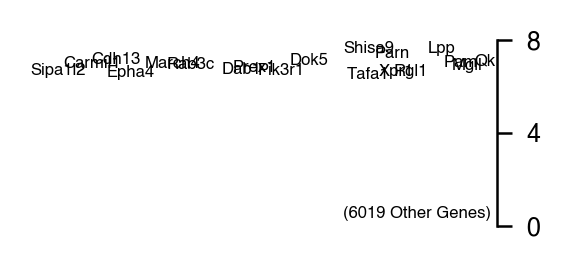

In [38]:
from matplotlib import patches
import numpy as np

label_y_cutoff = 6.5

df = other_sum_rs[other_sum_rs > label_y_cutoff]
other_count = other_sum_rs[other_sum_rs <= label_y_cutoff].size
df[f'({other_count} Other Genes)'] = 0.5

# c=[groupColors.get(langnameGroup[label],'k') for label in df.index]
fig = plt.figure(figsize=(2, 1), dpi=300)
gs = fig.add_gridspec(1, 10)

ax = fig.add_subplot(gs[0, :])
# ax_scatter = fig.add_subplot(gs[0, 9:])

ax.axes.get_xaxis().set_visible(False)
ax.set_xlim(-40, 0.1)
ax.set_ylim(0, 8)

ax.set_yticks([0, 4, 8])

ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.yaxis.set_label_position('right')
ax.yaxis.set_ticks_position('right')

plt.tight_layout()

patch = patches.Rectangle((-0.1, 0), 0.2, 100, fill=False, alpha=0)
# We add a rectangle to make sure the labels don't move to the right
ax.add_patch(patch)

texts = []
np.random.seed(0)
for label, y in zip(df.index, df):
    texts += [
        ax.text(
            -.1 + np.random.random() / 1000,
            y + np.random.random() / 1000,
            label,
            # A small random shift prevents labels
            # which have exactly the same coordinates from being stuck together
            # (not a problem in this example really, but wanted to mention this possibility)
            color='k',
            fontsize=4)
    ]
adjust_text(
    texts,
    [0 for _ in df],
    df,
    ha='left',
    va='center',
    add_objects=[patch],
    expand_text=(1.05, 1),
    # We want them to be quite compact, so reducing expansion makes sense
    force_text=(0.75, 0),
    force_objects=(1, 0),
    #With default forces it takes a very long time to converge,
    # but higher values still produce very nice output
    autoalign=False,
    only_move={
        'points': 'x',
        'text': 'x',
        'objects': 'x'
    })

fig.savefig('Exc.Other.total_rs.strip_plot.text_part.pdf', bbox_inches='tight')

In [27]:
other_sum_rs.max()

8.060553570026741

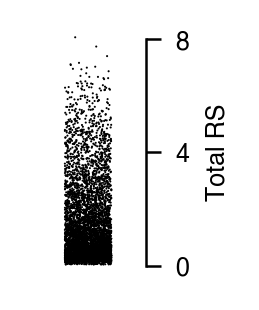

In [28]:
fig, ax = plt.subplots(figsize=(0.5, 1), dpi=300)
# other_sum_rs[other_sum_rs > 2.5] = 2.5
sns.stripplot(y=other_sum_rs, jitter=0.2, s=0.5, color='k', clip_on=False)
sns.despine(ax=ax, bottom=True, left=True, right=False)
ax.set_ylabel('Total RS')
ax.yaxis.set_label_position('right')
ax.yaxis.set_ticks_position('right')
ax.set_ylim(0, 8)
ax.set_yticks([0, 4, 8])
ax.set_xticks([])

fig.savefig('Exc.Other.total_rs.strip_plot.scatter_part.pdf',
            bbox_inches='tight')

In [21]:
tf_sum_rs.to_csv('exc.tf.sum_rs.csv', header=False)
other_sum_rs.to_csv('exc.other.sum_rs.csv', header=False)